<a href="https://colab.research.google.com/github/ParthikB/Crypto-Predictor/blob/master/krish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import keras
from keras.models import Sequential
from keras.layers import Dropout, LSTM, Dense

from sklearn.preprocessing import MinMaxScaler

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Variables

In [0]:
DATASET_PATH = '/content/drive/My Drive/Colab Notebooks/RNN_algorithmic trading/datasets/Binance_BTCUSDT_d.csv'
COL          = 'Open' # The column to predict
TIME_STAMP   = 60     # For how many time-stamps prediction has to be made
EPOCHS       = 100    # Number of Epochs
BATCH_SIZE   = 32     # Batch Size

In [16]:
# Reading the DATASET
df = pd.read_csv(DATASET_PATH)

# Converting the 'Date' column into pandas date_time format
df['Date'] = df['Date'].apply(pd.to_datetime)

# Setting the 'Date' col to be the index
df.index = df['Date']

# Sorting the Dataset on the basis of the index
df.sort_index(inplace=True)

df.head()

,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USDT
Date,,,,,,,,
2017-01-09,2017-01-09,BTCUSDT,4724.89,4885.55,4654.88,4834.91,554.18,2634056.29
2017-01-10,2017-01-10,BTCUSDT,4378.51,4406.52,4240.04,4378.48,724.90,3128231.71
2017-01-11,2017-01-11,BTCUSDT,6463.00,6774.67,6338.02,6753.98,1659.85,10848260.96
2017-01-12,2017-01-12,BTCUSDT,9838.96,10898.00,9380.00,10782.99,6033.85,61238619.44
2017-02-09,2017-02-09,BTCUSDT,4834.91,4939.19,4286.87,4472.14,888.18,4072965.36


In [18]:
# Seleting the column to predict
data = df[COL]

# Splitting the Data into Training and Test Set
TRAIN_SPLIT_PERCENTAGE = 0.9
part = (int(TRAIN_SPLIT_PERCENTAGE * len(data)))

train_data = data[:part].values.reshape(-1, 1)
test_data = data[part-TIME_STAMP:].values.reshape(-1, 1)

print(f"""Size of Training Data : {len(train_data)}
Size of Training Data : {len(test_data)}""")

Size of Training Data : 751
Size of Training Data : 144


### Data Preprocessing

In [0]:
# SCALING the data from 0-1
scale = MinMaxScaler(feature_range=(0,1))

train_data = scale.fit_transform(train_data)
test_data = scale.fit_transform(test_data)

### Creating X_train and Y_train

In [0]:
'''
Making a rolling window of TIME_STAMP where the output will be the next value
example output :
x = [1, 2, 3] >> y = [4]
x = [2, 3, 4] >> y = [5]
x = [3, 4, 5] >> y = [6]
here, TIME_STAMP = 3
'''

def create_data(data, TIME_STAMP=60):
    X, Y = [], []
    for i in range(TIME_STAMP, len(data)):
        x = data[i-TIME_STAMP : i]
        y = data[i]
        X.append(x)
        Y.append(y)
    return np.array(X), np.array(Y)



train_x, train_y = create_data(train_data, TIME_STAMP)
test_x, test_y   = create_data(test_data, TIME_STAMP)

# RESHAPING the Train/Test Features to match the Neural Network input dims
train_x = train_x.reshape(train_x.shape[0], TIME_STAMP , input_dim)
test_x  = test_x.reshape(test_x.shape[0], TIME_STAMP , input_dim)

## Creating the RNN

In [0]:
def create_model(input_data):
    
    # Defining a Model
    model = Sequential()
    
    # Adding an LSTM Input Layer with input_shape=(TIME_STAMP, 1)
    model.add(LSTM(units=50, return_sequences=True, input_shape=(input_data.shape[1], 1) ))
    model.add(Dropout(0.2)) # Adding a Dropout Layer to Generalize and minimize Overfitting
    
    # Adding a few more LSTMs as Hidden Layers
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    
    # Adding a Dense Output Layer with a Single output that wil give us our Prediction
    model.add(Dense(units=1))
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


def generate_model(input_features, input_labels, EPOCHS=10, BATCH_SIZE=32, model=None):
    
#     logdir = "logs/"
#     tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
    
    # Creating a New model if no previously trained model is availble
    if not model:
        model = create_model(input_features)
    
    # Fitting the values into the model, basically Training!
    model.fit(input_features, 
              input_labels, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE,) 
#               verbose=0, 
#               callbacks=[tensorboard_callback])    
    
    return model



EPOCHS     = 100
BATCH_SIZE = 32

# Load Model
# model = keras.models.load_model('saved_model/my_model')

model = generate_model(train_x, train_y, EPOCHS, BATCH_SIZE, model=None)

final_loss = model.history.history['loss'][-1]

# Save Model
# model.save(f'/content/drive/My Drive/Colab Notebooks/RNN_algorithmic trading/models/model_{round(final_loss, 5)}')


In [0]:
predictions = model.predict(test_x)

In [0]:
training_labels  = scale.inverse_transform(train_y)
original_labels  = scale.inverse_transform(test_y)
predicted_labels = scale.inverse_transform(predictions)

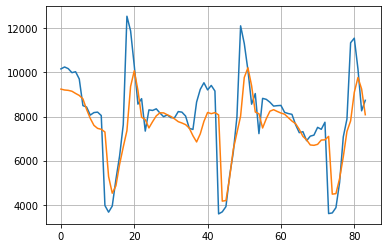

In [43]:
plt.plot(original_labels)
plt.plot(predicted_labels)
plt.grid(1)